# Load Images

In [1]:
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image

In [2]:
from google.cloud import storage
from google.oauth2 import service_account

In [3]:
def get_images_to_folder():
    
    #To change
    BUCKET_NAME = "youtube_optimizer_data" #Bucket name
    storage_dir = "bucket_data_short" #Folder in bucket that contains the images
    local_dir = "bucket_data_short/" #Create this manually in the same location as this file
    #Store the "massive-pen-365111-8eaed18fb748.json" file there as well

    my_credentials = service_account.Credentials.from_service_account_file("massive-pen-365111-8eaed18fb748.json")

    client = storage.Client(credentials=my_credentials)
    bucket = client.bucket(BUCKET_NAME)
    blob = bucket.blob(storage_dir)
    
    blobs = bucket.list_blobs(prefix =storage_dir)
    for blob in blobs:
        filename = blob.name.replace('/','_')
        blob.download_to_filename(local_dir + filename)

In [22]:
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 MB 691.8 kB/s eta 0:00:0000:0100:02


In [23]:
from google.cloud import storage

import numpy as np
import cv2

def load_data_direct(bucket_name):
    bucket = storage.Client().get_bucket(bucket_name)
    images = []
    count = 0
    for blob in bucket.list_blobs(prefix = 'lunch3'):
        if count < 5:
            images.append(
                cv2.imdecode(
                    np.asarray(bytearray(blob.download_as_string()), dtype=np.uint8), -1
                )

                #if blob.name.endswith(".jpg")
            )
            count += 1
        else:
            break
    return images

In [24]:
five_imgs = load_data_direct('mvp_youtube_otimizer')

NotFound: 404 GET https://storage.googleapis.com/storage/v1/b/mvp_youtube_otimizer?projection=noAcl&prettyPrint=false: The specified bucket does not exist.

In [ ]:
#Specify the path to the folder in which you just stored the images
def load_images_from_folder(bucket_name = 'mvp_youtube_optimizer'):
    images_data = load_data_direct(bucket_name)
    images = []
    views = []
    video_ids = []
    for filename in os.listdir(folder):
        last_underscore = filename.rfind('_')
        video_id = filename[len('bucket_data_short'):last_underscore-1] #enter name of the folder in the bucket that contains the images
        if video_id not in video_ids:
            video_ids.append(video_id)
            if len(filename)< len('bucket_data_short')+1: #enter name of the folder in the bucket that contains the images
                continue
    
            else:
                img = Image.open(os.path.join(folder,filename))
                img = np.array(img)
                #print(type(img))
                #img = plt.imread(os.path.join(folder,filename))
                if img.shape != (180,320,3):
                    continue
                else:
                    
                    y = int(filename[last_underscore +1:])
                    images.append(list(img))
                    views.append(y)
    return images, views


In [4]:
#Specify the path to the folder in which you just stored the images
def load_images_from_folder(folder='/Users/nicolafriedrich/code/jacksharples1/youtube_optimizer/bucket_data_short'):
    images = []
    views = []
    video_ids = []
    for filename in os.listdir(folder):
        last_underscore = filename.rfind('_')
        video_id = filename[len('bucket_data_short'):last_underscore-1] #enter name of the folder in the bucket that contains the images
        if video_id not in video_ids:
            video_ids.append(video_id)
            if len(filename)< len('bucket_data_short')+1: #enter name of the folder in the bucket that contains the images
                continue
    
            else:
                img = Image.open(os.path.join(folder,filename))
                img = np.array(img)
                #print(type(img))
                #img = plt.imread(os.path.join(folder,filename))
                if img.shape != (180,320,3):
                    continue
                else:
                    
                    y = int(filename[last_underscore +1:])
                    images.append(list(img))
                    views.append(y)
    return images, views


In [5]:
def dataloading():
    get_images_to_folder()
    X,y = load_images_from_folder()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [6]:
X_train, X_test, y_train, y_test = dataloading()

# Baseline model

In [7]:
from sklearn.metrics import mean_absolute_error

In [8]:
base_mae = np.mean(np.abs(y_train - np.mean(y_train)))

# Model

In [9]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import preprocess_input

2022-11-30 13:02:11.673242: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
def base_model():
    base_model = Xception(weights="imagenet",input_shape = (180,320,3),include_top=False)
    base_model.trainable = False
    return base_model

In [11]:
def complete_model():
    model = Sequential((
        base_model(),
        #GlobalAveragePooling2D(),
        AveragePooling2D(pool_size = (3,3)),
        Flatten(),
        Dense(50,activation = 'relu'),
        Dense(1,activation = 'linear')))
    
    opt = Adam(learning_rate=0.01, 
               beta_1=0.9, 
               beta_2=0.99)
    
    model.compile(loss="mae", optimizer='adam',
                  metrics=["mse"])
    
    return model  

In [12]:
model = complete_model()
model.summary()

2022-11-30 13:02:20.966121: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 6, 10, 2048)       20861480  
                                                                 
 average_pooling2d (AverageP  (None, 2, 3, 2048)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 50)                614450    
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 21,475,981
Trainable params: 614,501
Non-trainable params: 20,861,480
______________________________________

In [13]:
def preprocess(X_train, X_test):
    X_train = preprocess_input(X_train)
    X_test = preprocess_input(X_test)
    return X_train, X_test

In [14]:
X_train, X_test = preprocess(X_train,X_test)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience = 3, restore_best_weights = True)

In [16]:
history = model.fit(X_train,y_train, epochs = 1000,batch_size = 16,validation_split=0.2, callbacks = [es])

Epoch 1/1000
1/1 [==============================] - 8s 8s/step - loss: 10726.4619 - mse: 334682656.0000 - val_loss: 213352.2188 - val_mse: 45519167488.0000
Epoch 2/1000
1/1 [==============================] - 1s 812ms/step - loss: 10720.3037 - mse: 334535136.0000 - val_loss: 213347.3281 - val_mse: 45517082624.0000
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 10713.9619 - mse: 334373984.0000 - val_loss: 213342.2031 - val_mse: 45514895360.0000
Epoch 4/1000
1/1 [==============================] - 1s 807ms/step - loss: 10707.3623 - mse: 334205056.0000 - val_loss: 213336.9688 - val_mse: 45512663040.0000
Epoch 5/1000
1/1 [==============================] - 1s 816ms/step - loss: 10700.5986 - mse: 334031456.0000 - val_loss: 213331.6250 - val_mse: 45510381568.0000
Epoch 6/1000
1/1 [==============================] - 1s 738ms/step - loss: 10693.7051 - mse: 333854336.0000 - val_loss: 213326.1875 - val_mse: 45508063232.0000
Epoch 7/1000
1/1 [==============================] - 

1/1 [==============================] - 1s 1s/step - loss: 10388.1641 - mse: 323379616.0000 - val_loss: 213113.1562 - val_mse: 45417218048.0000
Epoch 53/1000
1/1 [==============================] - 1s 1s/step - loss: 10380.8877 - mse: 323065760.0000 - val_loss: 213107.0938 - val_mse: 45414633472.0000
Epoch 54/1000
1/1 [==============================] - 1s 921ms/step - loss: 10377.1670 - mse: 322751136.0000 - val_loss: 213101.8125 - val_mse: 45412380672.0000
Epoch 55/1000
1/1 [==============================] - 1s 1s/step - loss: 10375.4570 - mse: 322449376.0000 - val_loss: 213097.2344 - val_mse: 45410430976.0000
Epoch 56/1000
1/1 [==============================] - 1s 1s/step - loss: 10373.1650 - mse: 322159424.0000 - val_loss: 213093.2969 - val_mse: 45408751616.0000
Epoch 57/1000
1/1 [==============================] - 1s 828ms/step - loss: 10370.3418 - mse: 321880224.0000 - val_loss: 213089.9531 - val_mse: 45407326208.0000
Epoch 58/1000
1/1 [==============================] - 1s 776ms/step

1/1 [==============================] - 1s 942ms/step - loss: 10145.6611 - mse: 308698208.0000 - val_loss: 212943.3125 - val_mse: 45344854016.0000
Epoch 104/1000
1/1 [==============================] - 1s 760ms/step - loss: 10139.6113 - mse: 308331776.0000 - val_loss: 212939.4688 - val_mse: 45343215616.0000
Epoch 105/1000
1/1 [==============================] - 1s 808ms/step - loss: 10133.0518 - mse: 307970080.0000 - val_loss: 212936.1406 - val_mse: 45341798400.0000
Epoch 106/1000
1/1 [==============================] - 1s 785ms/step - loss: 10126.9668 - mse: 307612384.0000 - val_loss: 212932.5312 - val_mse: 45340262400.0000
Epoch 107/1000
1/1 [==============================] - 1s 845ms/step - loss: 10120.7607 - mse: 307235488.0000 - val_loss: 212927.6250 - val_mse: 45338173440.0000
Epoch 108/1000
1/1 [==============================] - 1s 995ms/step - loss: 10113.6592 - mse: 306830592.0000 - val_loss: 212921.5469 - val_mse: 45335584768.0000
Epoch 109/1000
1/1 [=============================

1/1 [==============================] - 1s 727ms/step - loss: 9742.4092 - mse: 284614880.0000 - val_loss: 212656.7500 - val_mse: 45222891520.0000
Epoch 155/1000
1/1 [==============================] - 1s 718ms/step - loss: 9732.6240 - mse: 284017568.0000 - val_loss: 212649.8281 - val_mse: 45219950592.0000
Epoch 156/1000
1/1 [==============================] - 1s 931ms/step - loss: 9722.6885 - mse: 283431328.0000 - val_loss: 212643.7188 - val_mse: 45217349632.0000
Epoch 157/1000
1/1 [==============================] - 1s 893ms/step - loss: 9712.0254 - mse: 282854816.0000 - val_loss: 212638.3750 - val_mse: 45215080448.0000
Epoch 158/1000
1/1 [==============================] - 1s 747ms/step - loss: 9700.6914 - mse: 282286752.0000 - val_loss: 212633.7188 - val_mse: 45213097984.0000
Epoch 159/1000
1/1 [==============================] - 1s 714ms/step - loss: 9692.5576 - mse: 281725984.0000 - val_loss: 212627.1875 - val_mse: 45210320896.0000
Epoch 160/1000
1/1 [==============================] - 1

1/1 [==============================] - 1s 781ms/step - loss: 9143.6494 - mse: 250757568.0000 - val_loss: 212239.4062 - val_mse: 45045567488.0000
Epoch 206/1000
1/1 [==============================] - 1s 781ms/step - loss: 9131.4150 - mse: 249975504.0000 - val_loss: 212228.7500 - val_mse: 45041041408.0000
Epoch 207/1000
1/1 [==============================] - 1s 755ms/step - loss: 9118.5713 - mse: 249208752.0000 - val_loss: 212219.2969 - val_mse: 45037031424.0000
Epoch 208/1000
1/1 [==============================] - 1s 762ms/step - loss: 9104.6924 - mse: 248455616.0000 - val_loss: 212210.9375 - val_mse: 45033480192.0000
Epoch 209/1000
1/1 [==============================] - 1s 714ms/step - loss: 9089.8662 - mse: 247714448.0000 - val_loss: 212203.5625 - val_mse: 45030350848.0000
Epoch 210/1000
1/1 [==============================] - 1s 731ms/step - loss: 9074.6064 - mse: 246983952.0000 - val_loss: 212195.1719 - val_mse: 45026791424.0000
Epoch 211/1000
1/1 [==============================] - 1

1/1 [==============================] - 1s 751ms/step - loss: 8351.8564 - mse: 209210240.0000 - val_loss: 211692.1094 - val_mse: 44813549568.0000
Epoch 257/1000
1/1 [==============================] - 1s 730ms/step - loss: 8334.2764 - mse: 208324288.0000 - val_loss: 211678.8750 - val_mse: 44807946240.0000
Epoch 258/1000
1/1 [==============================] - 1s 754ms/step - loss: 8316.5527 - mse: 207420992.0000 - val_loss: 211667.1250 - val_mse: 44802973696.0000
Epoch 259/1000
1/1 [==============================] - 1s 739ms/step - loss: 8298.5586 - mse: 206535216.0000 - val_loss: 211656.7188 - val_mse: 44798566400.0000
Epoch 260/1000
1/1 [==============================] - 1s 745ms/step - loss: 8282.3223 - mse: 205665104.0000 - val_loss: 211645.1875 - val_mse: 44793683968.0000
Epoch 261/1000
1/1 [==============================] - 1s 743ms/step - loss: 8264.8721 - mse: 204791504.0000 - val_loss: 211632.6562 - val_mse: 44788379648.0000
Epoch 262/1000
1/1 [==============================] - 1

1/1 [==============================] - 1s 760ms/step - loss: 7363.8276 - mse: 162661616.0000 - val_loss: 211008.8281 - val_mse: 44524724224.0000
Epoch 308/1000
1/1 [==============================] - 1s 744ms/step - loss: 7342.7798 - mse: 161693104.0000 - val_loss: 210994.6875 - val_mse: 44518756352.0000
Epoch 309/1000
1/1 [==============================] - 1s 725ms/step - loss: 7322.8403 - mse: 160744688.0000 - val_loss: 210979.3906 - val_mse: 44512305152.0000
Epoch 310/1000
1/1 [==============================] - 1s 778ms/step - loss: 7301.4141 - mse: 159796320.0000 - val_loss: 210963.0469 - val_mse: 44505407488.0000
Epoch 311/1000
1/1 [==============================] - 1s 752ms/step - loss: 7279.6855 - mse: 158848032.0000 - val_loss: 210948.5469 - val_mse: 44499288064.0000
Epoch 312/1000
1/1 [==============================] - 1s 937ms/step - loss: 7257.8647 - mse: 157917728.0000 - val_loss: 210935.6875 - val_mse: 44493864960.0000
Epoch 313/1000
1/1 [==============================] - 1

1/1 [==============================] - 1s 799ms/step - loss: 6188.5630 - mse: 114745912.0000 - val_loss: 210196.9844 - val_mse: 44182773760.0000
Epoch 359/1000
1/1 [==============================] - 1s 776ms/step - loss: 6160.8755 - mse: 113852824.0000 - val_loss: 210183.0625 - val_mse: 44176920576.0000
Epoch 360/1000
1/1 [==============================] - 1s 931ms/step - loss: 6138.4414 - mse: 112941688.0000 - val_loss: 210165.5781 - val_mse: 44169568256.0000
Epoch 361/1000
1/1 [==============================] - 1s 812ms/step - loss: 6115.0796 - mse: 111997920.0000 - val_loss: 210146.8594 - val_mse: 44161703936.0000
Epoch 362/1000
1/1 [==============================] - 1s 812ms/step - loss: 6090.0522 - mse: 111057248.0000 - val_loss: 210127.0469 - val_mse: 44153376768.0000
Epoch 363/1000
1/1 [==============================] - 1s 812ms/step - loss: 6063.3042 - mse: 110119640.0000 - val_loss: 210106.2344 - val_mse: 44144627712.0000
Epoch 364/1000
1/1 [==============================] - 1

1/1 [==============================] - 1s 1s/step - loss: 4823.0552 - mse: 69742472.0000 - val_loss: 209258.2969 - val_mse: 43789033472.0000
Epoch 410/1000
1/1 [==============================] - 1s 763ms/step - loss: 4793.9600 - mse: 68925888.0000 - val_loss: 209238.6875 - val_mse: 43780829184.0000
Epoch 411/1000
1/1 [==============================] - 1s 802ms/step - loss: 4765.2368 - mse: 68111168.0000 - val_loss: 209218.9844 - val_mse: 43772583936.0000
Epoch 412/1000
1/1 [==============================] - 1s 726ms/step - loss: 4736.7944 - mse: 67285096.0000 - val_loss: 209197.9062 - val_mse: 43763765248.0000
Epoch 413/1000
1/1 [==============================] - 1s 703ms/step - loss: 4708.0488 - mse: 66462604.0000 - val_loss: 209179.1562 - val_mse: 43755921408.0000
Epoch 414/1000
1/1 [==============================] - 1s 710ms/step - loss: 4678.5327 - mse: 65658380.0000 - val_loss: 209158.9062 - val_mse: 43747446784.0000
Epoch 415/1000
1/1 [==============================] - 1s 716ms/s

Epoch 461/1000
1/1 [==============================] - 1s 770ms/step - loss: 3242.7800 - mse: 31543242.0000 - val_loss: 208167.3125 - val_mse: 43333632000.0000
Epoch 462/1000
1/1 [==============================] - 1s 735ms/step - loss: 3213.7258 - mse: 30894416.0000 - val_loss: 208143.6562 - val_mse: 43323781120.0000
Epoch 463/1000
1/1 [==============================] - 1s 751ms/step - loss: 3182.6487 - mse: 30264394.0000 - val_loss: 208122.6094 - val_mse: 43315019776.0000
Epoch 464/1000
1/1 [==============================] - 1s 912ms/step - loss: 3149.4016 - mse: 29651480.0000 - val_loss: 208103.9062 - val_mse: 43307237376.0000
Epoch 465/1000
1/1 [==============================] - 1s 763ms/step - loss: 3116.9543 - mse: 29054270.0000 - val_loss: 208083.3125 - val_mse: 43298664448.0000
Epoch 466/1000
1/1 [==============================] - 1s 1s/step - loss: 3084.7600 - mse: 28460688.0000 - val_loss: 208061.0156 - val_mse: 43289387008.0000
Epoch 467/1000
1/1 [=============================

Epoch 513/1000
1/1 [==============================] - 1s 805ms/step - loss: 1482.5933 - mse: 6536875.5000 - val_loss: 206952.0312 - val_mse: 42829144064.0000
Epoch 514/1000
1/1 [==============================] - 1s 810ms/step - loss: 1447.4049 - mse: 6225385.5000 - val_loss: 206929.6250 - val_mse: 42819870720.0000
Epoch 515/1000
1/1 [==============================] - 1s 922ms/step - loss: 1409.8956 - mse: 5926078.5000 - val_loss: 206909.7344 - val_mse: 42811637760.0000
Epoch 516/1000
1/1 [==============================] - 1s 1s/step - loss: 1372.8234 - mse: 5638200.5000 - val_loss: 206889.3125 - val_mse: 42803187712.0000
Epoch 517/1000
1/1 [==============================] - 1s 1s/step - loss: 1340.2084 - mse: 5351366.5000 - val_loss: 206864.0156 - val_mse: 42792722432.0000
Epoch 518/1000
1/1 [==============================] - 1s 1s/step - loss: 1302.4359 - mse: 5061644.5000 - val_loss: 206834.3125 - val_mse: 42780434432.0000
Epoch 519/1000
1/1 [==============================] - 1s 1s/s

In [17]:
def plot_history(history, title='', axs=None, exp_name=""):
    plt.plot(history.history['loss'], label='train' + exp_name)
    plt.plot(history.history['val_loss'], label='val' + exp_name)
    plt.legend()

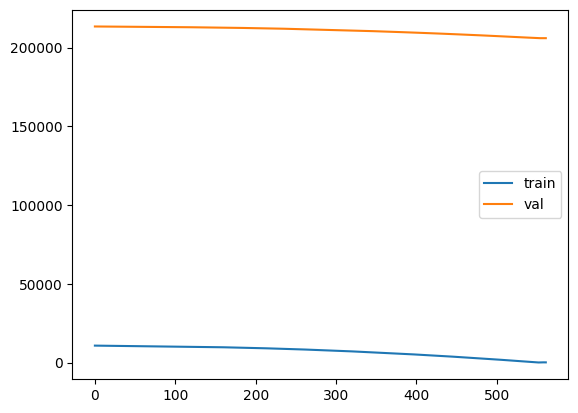

In [18]:
plot_history(history)

In [19]:
min(history.history['val_loss'])

205912.796875

In [20]:
improvement = (base_mae - 2541534.7500)/base_mae
improvement

-32.44729803089375